In [2]:
import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
from qiskit import Aer
from tqdm.notebook import tqdm

import sys
sys.path.insert(0, '../../src/')
from neuralnetwork import *
from samplers import *

#%matplotlib notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

## QNN

### Fitting Gaussian

In [ ]:
np.random.seed(43)
backend = Aer.get_backend('qasm_simulator')

layer1 = QLayer(n_qubits=1, 
                n_features=1, 
                n_targets=3, 
                encoder=Encoder(), 
                ansatz=Ansatz(blocks=["ry", "entangle"]), 
                sampler=Parity(), 
                scale=[-np.pi, np.pi], 
                backend=backend, 
                shots=10000)

layer2 = QLayer(n_qubits=3, 
                n_features=3, 
                n_targets=1, 
                encoder=Encoder(), 
                ansatz=Ansatz(blocks=["ry", "entangle"]), 
                sampler=Parity(), 
                scale=1, 
                backend=backend, 
                shots=10000)


layers = [layer1, layer2]

optimizer = Adam(lr=0.1)
network = NeuralNetwork(layers)

In [ ]:
print(network.weight)

In [ ]:
x = np.linspace(0, np.pi, 21).reshape(-1,1)
y = 0.9*np.exp(-3*(x-np.pi/2)**2) + 0.05

x = scaler(x, a=-np.pi/2, b=np.pi/2)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()


for i in tqdm(range(100)):
    network.backward(x, y)
    network.step()
    y_pred = network.predict(x)
    
    ax.clear()
    ax.plot(x, y)
    ax.plot(x, y_pred)
    ax.set_ylim([0, 1])
    fig.canvas.draw()

### Derivative

In [ ]:
y_pred = network.predict(x)
deriv = network.deriv(x)

In [ ]:
y_deriv_num = (y[1:] - y[:-1])/(x[1]-x[0])

In [ ]:
#plt.plot(x,y)
#plt.plot(x,y_pred)
plt.plot(x[:-1], y_deriv_num)
plt.plot(x, deriv)
plt.show()

### Sequential

In [ ]:
np.random.seed(42)
network = sequential_qnn(q_bits = [1, 3, 3],
                         dim = [1, 3, 3, 1],
                         reps=1,
                         backend = backend,
                         shots = 10000)

In [ ]:
x = np.linspace(0, np.pi, 21).reshape(-1,1)
y = 0.9*np.exp(-3*(x-np.pi/2)**2) + 0.05

#network.train(x, y, epochs=100, verbose=True)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()


for i in tqdm(range(100)):
    network.backward(x, y)
    network.step()
    y_pred = network.predict(x)
    
    ax.clear()
    ax.plot(x, y)
    ax.plot(x, y_pred)
    ax.set_ylim([0, 1])
    fig.canvas.draw()

#### Chaotic

In [ ]:
np.random.seed(42)
backend = Aer.get_backend('qasm_simulator')

layer1 = QLayer(n_qubits=1, n_features=1, n_targets=3, encoder=Encoder(), ansatz=Ansatz(), reps=1, scale=np.pi, backend=backend, shots=2000)
layer2 = QLayer(n_qubits=3, n_features=3, n_targets=3, encoder=Encoder(), ansatz=Ansatz(), reps=1, scale=np.pi, backend=backend, shots=2000)
layer3 = QLayer(n_qubits=3, n_features=3, n_targets=1, encoder=Encoder(), ansatz=Ansatz(), reps=1, scale=1, backend=backend, shots=2000)


layers = [layer1, layer2, layer3]

optimizer = Adam(lr=0.01)
network = NeuralNetwork(layers, optimizer)

In [ ]:
np.random.seed(42)
x = np.linspace(0, 1, 10).reshape(-1,1)
y = np.random.uniform(0, 1, 10).reshape(-1,1)

network.backward(x, y)


fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()



for i in tqdm(range(100)):
    
    y_pred = network.predict(x)
    
    network.backward(x, y)
    network.step()
    ax.clear()
    ax.plot(x, y)
    ax.plot(x, y_pred)
    ax.set_ylim([0, 1])
    fig.canvas.draw()

#### Sigmoid

In [ ]:
np.random.seed(42)
x = np.random.uniform(0, np.pi/2, (20, 3))
beta = np.array([1,1,1]).reshape(-1,1)

z = (x-np.pi/4)@beta
y = 1/(1+np.exp(-2*z))


plt.plot(z, y, "o")
plt.show()

In [ ]:
np.random.seed(42)
backend = Aer.get_backend('qasm_simulator')

model = sequential_qnn(q_bits = [3],
                     dim = [3, 1],
                     reps = 2,
                     backend=backend,
                     shots=10000,
                     lr = 0.1)

model.train(x, y, epochs=50, verbose=True)

In [ ]:
y_pred = model.predict(x)

In [ ]:
plt.plot(z, y, "o")
plt.plot(z, y_pred, "o")
plt.show()

#### ReLu

In [ ]:
np.random.seed(42)
x = np.random.uniform(0, np.pi/2, (20, 3))
beta = np.array([1/3,-2/3,1/3]).reshape(-1,1)
z = x@beta
y = z*(0<z).astype(float)+0.1

#plt.plot(z, y, "o")
#plt.show()

In [ ]:
np.random.seed(39)
backend = Aer.get_backend('qasm_simulator')

layer1 = QLayer(n_qubits=3, n_inputs=3, n_outputs=1, encoder=Encoder(), ansatz=Ansatz(), reps=3, scale=1, backend=backend, shots=1000)
layers = [layer1]

optimizer = Adam(lr=0.01)
network = QNN(layers, optimizer)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()


for i in tqdm(range(200)):
    network.backward(x, y)

    y_pred = []
    for x_ in x:
        network(x_)
        y_pred.append(network.a[-1])
    
    network.step()
    
    ax.clear()
    ax.plot(z, y, "o")
    ax.plot(z, y_pred, "o")
    ax.set_ylim([0, 1])
    fig.canvas.draw()

#### Radial Basis

In [ ]:
np.random.seed(42)
x = np.random.uniform(0, np.pi/2, (20, 3))
beta = np.array([1/3,-2/3,1/3]).reshape(-1,1)
z = x@beta
y = 0.8*np.exp(-(z**2)/0.1) + 0.1

plt.plot(z, y, "o")
plt.show()

In [ ]:
np.random.seed(42)
backend = Aer.get_backend('qasm_simulator')

model = sequential_qnn(q_bits = [3],
                     dim = [3, 1],
                     reps = 2,
                     backend=backend,
                     shots=10000,
                     lr = 0.1)

model.train(x, y, epochs=100, verbose=True)

In [ ]:
y_pred = model.predict(x)

In [ ]:
plt.plot(z, y, "o")
plt.plot(z, y_pred, "o")
plt.show()

#### Classical NN

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.layer1 = nn.Linear(3, 2)
        self.layer2 = nn.Linear(2, 1)

    def forward(self, x):
        x = torch.tanh(self.layer1(x))
        x = self.layer2(x)
        return x

In [ ]:
np.random.seed(42)
x = np.random.uniform(0, np.pi/2, (20, 3))
beta = np.array([1/3,-2/3,1/3]).reshape(-1,1)
#z = (x-np.pi/4)@beta

z = x@beta
#y = 1/(1+np.exp(-3*z))

y = 0.8*np.exp(-(z**2)/0.1) + 0.1
#y = z*(0<z).astype(float)+0.1


x = torch.tensor(x, dtype = torch.float, requires_grad=False)
y = torch.tensor(y, dtype = torch.float, requires_grad=False)

model = Model()
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for i in tqdm(range(200)):
    optimizer.zero_grad()
    y_pred = model(x)
    loss = loss_func(y_pred, y)
    loss.backward()
    print(loss.detach())
    optimizer.step()
    
    ax.clear()
    ax.plot(z, y.detach(), "o")
    ax.plot(z, y_pred.detach(), "o")
    ax.set_ylim([-0.2, 1.2])
    fig.canvas.draw()

#### Ost

In [ ]:
np.random.seed(42)
backend = Aer.get_backend('qasm_simulator')

layer1 = CLayer(n_inputs=1, n_outputs=3, scale = 1, activation = torch.tanh)
layer2 = CLayer(n_inputs=3, n_outputs=1, scale = 1, activation = torch.tanh)
layers = [layer1, layer2]

optimizer = Adam(lr=0.01)
network = QNN(layers, optimizer)

In [ ]:
x = np.linspace(0, 1, 10).reshape(-1,1)
y = 0.9*np.exp(-10*(x-0.5)**2)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for i in tqdm(range(100)):
    network.backward(x, y)

    y_pred = []
    for x_ in x:
        network(x_)
        y_pred.append(network.a[-1])
    
    network.step()
    ax.clear()
    ax.plot(x, y)
    ax.plot(x, y_pred)
    ax.set_ylim([0, 1])
    fig.canvas.draw()

In [3]:
x = np.linspace(-np.pi/2, np.pi/2, 30)

x = generate_meshgrid([x,x])

In [4]:
print(x.shape)

(900, 2)


In [17]:
np.random.seed(44)
backend = Aer.get_backend('qasm_simulator')

qkn1 = sequential_qnn(n_qubits = [2],
                         dim = [2, 1],
                         encoder = Encoder(),
                         ansatz = Ansatz(blocks=["entangle", "ry"], reps=2),
                         sampler = Parity(),
                         backend = backend,
                         shots = 10000)

qkn2 = sequential_qnn(n_qubits = [2, 4],
                         dim = [2, 4, 1],
                         encoder = Encoder(),
                         ansatz = Ansatz(blocks=["entangle", "ry"], reps=2),
                         sampler = Parity(),
                         backend = backend,
                         shots = 10000)

qkn3 = sequential_qnn(n_qubits = [2, 4, 4],
                         dim = [2, 4, 4, 1],
                         encoder = Encoder(),
                         sampler = Parity(),
                         ansatz = Ansatz(blocks=["entangle", "ry"], reps=2),
                         backend = backend,
                         shots = 10000)

qkn4 = sequential_qnn(n_qubits = [2, 4, 4, 4],
                         dim = [2, 4, 4, 4, 1],
                         encoder = Encoder(),
                         ansatz = Ansatz(blocks=["entangle", "ry"], reps=2),
                         sampler = Parity(),
                         backend = backend,
                         shots = 10000)

In [18]:
y_pred1 = qkn1.predict(x).reshape(30,30)
y_pred2 = qkn2.predict(x).reshape(30,30)
y_pred3 = qkn3.predict(x).reshape(30,30)
y_pred4 = qkn4.predict(x).reshape(30,30)

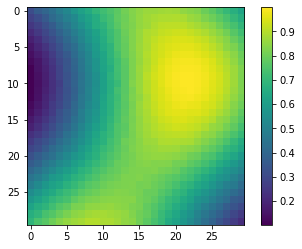

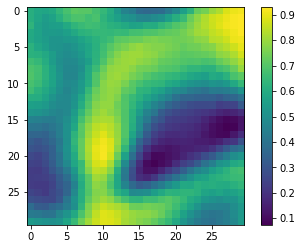

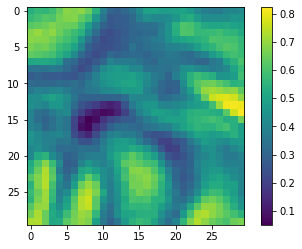

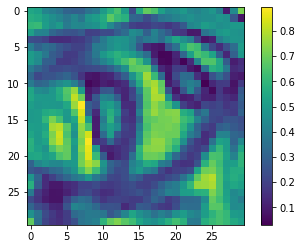

In [19]:
plt.imshow(y_pred1)
plt.colorbar()
plt.show()

plt.imshow(y_pred2)
plt.colorbar()
plt.show()

plt.imshow(y_pred3)
plt.colorbar()
plt.show()

plt.imshow(y_pred4)
plt.colorbar()
plt.show()

In [10]:
np.random.seed(43)

dnn1 = sequential_dnn(dim = [2, 1],)
dnn2 = sequential_dnn(dim = [2, 6, 1])
dnn3 = sequential_dnn(dim = [2, 6, 6, 1])
dnn4 = sequential_dnn(dim = [2, 6, 6, 6, 1])

In [11]:
x = scaler(x, mode="standard")

In [12]:
y_pred5 = dnn1.predict(x).reshape(30,30)
y_pred6 = dnn2.predict(x).reshape(30,30)
y_pred7 = dnn3.predict(x).reshape(30,30)
y_pred8 = dnn4.predict(x).reshape(30,30)

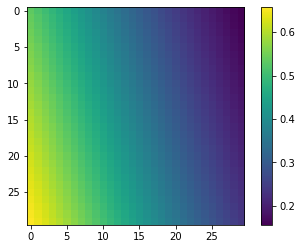

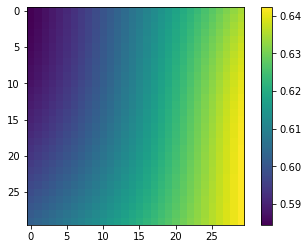

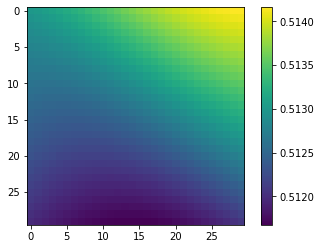

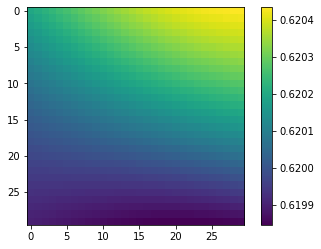

In [14]:
plt.imshow(y_pred5)
plt.colorbar()
plt.show()

plt.imshow(y_pred6)
plt.colorbar()
plt.show()

plt.imshow(y_pred7)
plt.colorbar()
plt.show()

plt.imshow(y_pred8)
plt.colorbar()
plt.show()